In [3]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import geopandas as gp

In [4]:
abridged = pd.read_csv('abridged_couties.csv')

---

## County Pres. 2000 - 2016

In [5]:
county_pres_df = pd.read_csv('countypres_2000-2016.csv')
county_pres_df = county_pres_df[(county_pres_df['party'] == 'democrat') | (county_pres_df['party'] == 'republican')]
county_pres_df.dropna(inplace=True)
county_pres_df = county_pres_df[(county_pres_df['county'] != 'Broomfield') & 
                                (county_pres_df['county'] != 'Kansas City') &
                                (county_pres_df['county'] != 'Bedford')]
county_pres_df.head()

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
1,2000,Alabama,AL,Autauga,1001.0,President,George W. Bush,republican,11993.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203
5,2000,Alabama,AL,Baldwin,1003.0,President,George W. Bush,republican,40872.0,56480,20191203
8,2000,Alabama,AL,Barbour,1005.0,President,Al Gore,democrat,5188.0,10395,20191203


In [6]:
def Get_Counties(df, state):
    """
    df: 
    state: U.S. State Name
    
    Returns 2-Dimensional Numpy array of U.S. States' Counties and FIPS Codes.
    """
    
    state_df = df[df['state'] == state]
    counties = state_df['county'].unique()
    fips = state_df['FIPS'].unique()
    
    return np.array([counties, fips])

def County_Winners(df, state):
    """
    df: 
    state_po: State Postal Code in the form CA, AL, etc.
    
    Returns 
    """
    
    state_df = df[df['state'] == state]
    election_years = state_df['year'].unique()
    winners_container = [[] for _ in range(len(election_years))]
    
    for idx, year in enumerate(election_years):
        winners = state_df[state_df['year'] == year].groupby('FIPS').apply(
            lambda county: county['party'][county['candidatevotes'].idxmax()]).values
        winners_container[idx] = winners
    
    return winners_container

def County_Winners_DF(df):
    """
    df: 
    
    Returns 
    """
    states = df['state'].unique()
    list_counties, list_fips = [], []
    list_2000, list_2004 = [], []
    list_2008, list_2012 = [], []
    list_2016 = []
    
    for state in states:
        counties = Get_Counties(df=df, state=state)
        county_winners = County_Winners(df=df, state=state)
        list_counties.extend(counties[0])
        list_fips.extend(counties[1])
        list_2000.extend(county_winners[0])
        list_2004.extend(county_winners[1])
        list_2008.extend(county_winners[2])
        list_2012.extend(county_winners[3])
        list_2016.extend(county_winners[4])
    
    final_dataframe = pd.DataFrame({
    'countyFIPS': list_fips,
    '2000': list_2000, '2004': list_2004, 
    '2008': list_2008, '2012': list_2012,
    '2016': list_2016})
    
    final_dataframe.replace({'republican': 1, 'democrat': 0}, inplace=True)
    final_dataframe['Total'] = final_dataframe.loc[:, ('2000', '2004', '2008', '2012', '2016')].sum(axis=1)
    
    return final_dataframe

In [12]:
cwdf = County_Winners_DF(county_pres_df)

In [13]:
test = county_pres_df[(county_pres_df['year'] == 2000) & (county_pres_df['state_po'] == 'AL')]
test.iloc[::2]

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
0,2000,Alabama,AL,Autauga,1001.0,President,Al Gore,democrat,4942.0,17208,20191203
4,2000,Alabama,AL,Baldwin,1003.0,President,Al Gore,democrat,13997.0,56480,20191203
8,2000,Alabama,AL,Barbour,1005.0,President,Al Gore,democrat,5188.0,10395,20191203
12,2000,Alabama,AL,Bibb,1007.0,President,Al Gore,democrat,2710.0,7101,20191203
16,2000,Alabama,AL,Blount,1009.0,President,Al Gore,democrat,4977.0,17973,20191203
...,...,...,...,...,...,...,...,...,...,...,...
248,2000,Alabama,AL,Tuscaloosa,1125.0,President,Al Gore,democrat,24614.0,60114,20191203
252,2000,Alabama,AL,Walker,1127.0,President,Al Gore,democrat,11621.0,25641,20191203
256,2000,Alabama,AL,Washington,1129.0,President,Al Gore,democrat,3386.0,7596,20191203
260,2000,Alabama,AL,Wilcox,1131.0,President,Al Gore,democrat,3444.0,5126,20191203


In [14]:
(county_pres_df[1::2]['candidatevotes'].values > county_pres_df[1::2]['candidatevotes'].values).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [15]:
abridged['countyFIPS'] = abridged['countyFIPS'][:-2].astype(int, copy=False)
merged = abridged.merge(cwdf, on='countyFIPS', how='inner')
merged

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,2000,2004,2008,2012,2016,Total
0,1001.0,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,0.4354,NaN,NaN,NaN,1,1,1,1,1,5
1,1003.0,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,0.2162,NaN,NaN,NaN,1,1,1,1,1,5
2,1005.0,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,0.9959,6.08,5400.0,18241.0,0,1,1,0,1,3
3,1007.0,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,0.6003,2.75,14980.0,6120.0,1,1,1,1,1,5
4,1009.0,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,0.4242,7.21,31850.0,25233.0,1,1,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,56039.0,56.0,39.0,Teton,WY,Wyoming,43.713556,-110.570974,43.494174,-110.784353,...,0.1127,NaN,NaN,NaN,1,0,0,0,0,1
3107,56041.0,56.0,41.0,Uinta,WY,Wyoming,41.289323,-110.553036,41.271860,-110.767519,...,0.4522,NaN,NaN,NaN,1,1,1,1,1,5
3108,56043.0,56.0,43.0,Washakie,WY,Wyoming,43.909060,-107.679282,44.012142,-107.911552,...,0.3732,NaN,NaN,NaN,1,1,1,1,1,5
3109,56045.0,56.0,45.0,Weston,WY,Wyoming,43.843456,-104.556904,43.910214,-104.312414,...,0.3475,0.44,5250.0,1532.0,1,1,1,1,1,5


In [16]:
cols = ['stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'Total']
o = merged.loc[:, cols]
o.dropna(inplace=True)
o

,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,Total
0,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,5
1,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,5
2,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,3
3,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,5
4,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,5
...,...,...,...,...,...,...,...
3106,737512.0,737504.0,737504.0,737504.0,737503.0,737503.0,1
3107,737512.0,737504.0,737504.0,737504.0,737503.0,737503.0,5
3108,737512.0,737504.0,737504.0,737504.0,737503.0,737503.0,5
3109,737512.0,737504.0,737504.0,737504.0,737503.0,737503.0,5


In [17]:
model = LinearRegression()
model.fit(o.iloc[:, :-1], o.iloc[:, -1])
model.score(o.iloc[:, :-1], o.iloc[:, -1])

0.03742488704282565

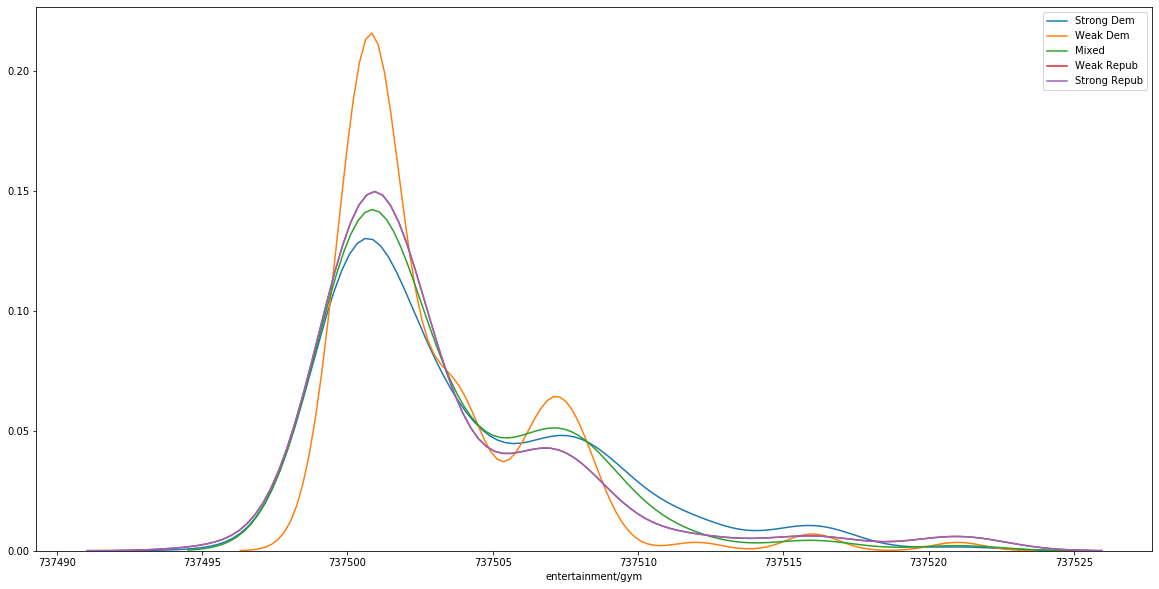

In [25]:
plt.figure(figsize=(20,10))
col = 5

sns.distplot(o[o['Total'] == 0].iloc[:,col], hist=False, label='Strong Dem')
sns.distplot(o[o['Total'] == 1].iloc[:,col], hist=False, label='Weak Dem')
sns.distplot(o[o['Total'] == 2].iloc[:,col], hist=False, label='Mixed')
sns.distplot(o[o['Total'] == 3].iloc[:,col], hist=False, label='Weak Repub')
sns.distplot(o[o['Total'] == 3].iloc[:,col], hist=False, label='Strong Repub')
plt.legend();

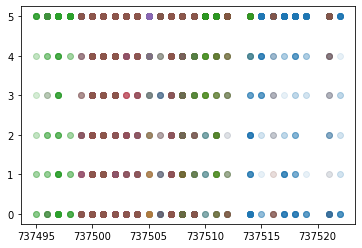

In [19]:
#o = o[(o['Total'] == 5) | (o['Total'] == 0)]
plt.plot(o.iloc[:, :-1], o.iloc[:, -1], 'o', alpha=.1)

In [20]:
#o = o[(o['Total'] == 5) | (o['Total'] == 0)]

model = LogisticRegression()
model.fit(o.iloc[:, :-1], o.iloc[:, -1])
model.score(o.iloc[:, :-1], o.iloc[:, -1])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



0.6577642121327737

In [969]:
abridged[abridged['StateName'] == 'AK']

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
67,2013.0,2.0,13.0,Aleutians East,AK,NaN,NaN,NaN,54.860151,-162.901536,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.5803,1.290,1400.0,4528.0
68,2016.0,2.0,16.0,Aleutians West,AK,NaN,NaN,NaN,54.023571,-168.292885,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.4927,2.090,350.0,7323.0
69,2020.0,2.0,20.0,Anchorage,AK,NaN,NaN,NaN,61.192232,-149.793182,...,737506.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.4602,21.311,16167.0,63934.0
70,2050.0,2.0,50.0,Bethel,AK,NaN,NaN,NaN,60.679946,-162.151263,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.9748,5.130,7000.0,17947.0
71,2060.0,2.0,60.0,Bristol Bay,AK,NaN,NaN,NaN,58.735464,-156.834047,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.3525,0.670,105.0,2357.0
72,2068.0,2.0,68.0,Denali,AK,NaN,NaN,NaN,63.882845,-149.032949,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.1010,1.470,0.0,5134.0
73,2070.0,2.0,70.0,Dillingham,AK,NaN,NaN,NaN,59.136256,-158.718472,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.8682,NaN,NaN,NaN
74,2090.0,2.0,90.0,Fairbanks North Star,AK,NaN,NaN,NaN,64.831552,-147.624018,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.3446,NaN,NaN,NaN
75,2100.0,2.0,100.0,Haines,AK,NaN,NaN,NaN,59.264125,-135.559897,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.2070,NaN,NaN,NaN
76,2110.0,2.0,110.0,Juneau,AK,NaN,NaN,NaN,58.358516,-134.530605,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.2987,NaN,NaN,NaN


In [ ]:
#counties = get_counties(df=df, state_po=state_po)
#make sure that is pre declared object in final func so as to now call twice

In [922]:
df = copy
states = df['state'].unique()
list_fips = []
list_2000, list_2004 = [], []
list_2008, list_2012 = [], []
list_2016 = []

for state in states:
    counties = Get_Counties(df=df, state=state)
    county_winners = County_Winners(df=df, state=state)
    list_fips.extend(counties[1])
    list_2000.extend(county_winners[0])
    list_2004.extend(county_winners[1])
    list_2008.extend(county_winners[2])
    list_2012.extend(county_winners[3])
    list_2016.extend(county_winners[4])

In [923]:
final_dataframe = pd.DataFrame({
    'county': list_fips, 
    '2000': list_2000, '2004': list_2004, 
    '2008': list_2008, '2012': list_2012,
    '2016': list_2016})

In [924]:
len(list_fips)

3148

In [925]:
len(list_2016)

3148

In [910]:
len(list_counties)

3147

In [921]:
copy = pd.read_csv('countypres_2000-2016.csv')
copy = copy[(copy['party'] == 'democrat') | (copy['party'] == 'republican')]
copy = copy[(copy['county'] != 'Broomfield') & (copy['county'] != 'Kansas City') & (copy['county'] != 'Bedford')]
copy.dropna(inplace=True)

In [818]:
copy[copy['totalvotes'] < 100]

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
20396,2004,Texas,TX,Loving,48301.0,President,John Kerry,democrat,12.0,80,20191203
20397,2004,Texas,TX,Loving,48301.0,President,George W. Bush,republican,65.0,80,20191203
29747,2008,Texas,TX,Loving,48301.0,President,Barack Obama,democrat,12.0,79,20191203
29748,2008,Texas,TX,Loving,48301.0,President,John McCain,republican,67.0,79,20191203
39098,2012,Texas,TX,Loving,48301.0,President,Barack Obama,democrat,9.0,64,20191203
39099,2012,Texas,TX,Loving,48301.0,President,Mitt Romney,republican,54.0,64,20191203
48449,2016,Texas,TX,Loving,48301.0,President,Hillary Clinton,democrat,4.0,65,20191203
48450,2016,Texas,TX,Loving,48301.0,President,Donald Trump,republican,58.0,65,20191203


In [861]:
copy[copy['state'] == 'Alaska']

,year,state,state_po,county,FIPS,office,candidate,party,candidatevotes,totalvotes,version
49868,2000,Alaska,AK,District 1,2001.0,President,Al Gore,democrat,1284.0,6656,20191203
49869,2000,Alaska,AK,District 1,2001.0,President,George W. Bush,republican,4681.0,6656,20191203
49872,2000,Alaska,AK,District 2,2002.0,President,Al Gore,democrat,2081.0,7388,20191203
49873,2000,Alaska,AK,District 2,2002.0,President,George W. Bush,republican,4235.0,7388,20191203
49876,2000,Alaska,AK,District 3,2003.0,President,Al Gore,democrat,3693.0,8225,20191203
...,...,...,...,...,...,...,...,...,...,...,...
50513,2016,Alaska,AK,District 38,2038.0,President,Donald Trump,republican,1143.0,5095,20191203
50515,2016,Alaska,AK,District 39,2039.0,President,Hillary Clinton,democrat,3142.0,5639,20191203
50516,2016,Alaska,AK,District 39,2039.0,President,Donald Trump,republican,1405.0,5639,20191203
50518,2016,Alaska,AK,District 40,2040.0,President,Hillary Clinton,democrat,2338.0,4610,20191203


In [931]:
cut = abridged[:-5][abridged['countyFIPS'][:-5].astype(int) < 56045.0]
cut

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3234,02105,2.0,105.0,Hoonah–Angoon Census Area,AK,NaN,NaN,NaN,58.078282,-135.384163,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.4178,0.40,700.0,1417.0
3235,02195,2.0,195.0,Petersburg Borough,AK,NaN,NaN,NaN,56.812712,-133.115025,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.6650,NaN,NaN,NaN
3236,02198,2.0,198.0,Prince of Wales-Hyder Census Area,AK,NaN,NaN,NaN,55.448164,-132.560842,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.7662,1.50,1050.0,5260.0
3237,02230,2.0,230.0,Skagway Municipality,AK,NaN,NaN,NaN,59.464536,-135.311501,...,737508.0,737503.0,737501.0,737501.0,737500.0,737495.0,0.1685,0.69,175.0,2412.0


In [838]:
abridged[abridged['countyFIPS'] == '78030']

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
3231,78030,NaN,NaN,St. Thomas,VI,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.06,48450.0,3184.0


In [887]:
atlas = pd.read_csv('atlas/2000_0_0_2.csv')
atlas = atlas[1:]
atlas['FIPS'] = atlas['FIPS'].astype(int, copy=False)

In [892]:
atlas[atlas['FIPS'] < 2001]

,FIPS,Geographic Name,Geographic Subtype,Total Vote,Albert Gore Jr.,George W. Bush,Ralph Nader,Patrick Buchanan,Harry Browne,Howard Phillips,...,James Harris,L. Neil Smith,David McReynolds,Monica Moorehead,None o.t. Candidates,Cathy Brown,Denny Lane,Randall Venson,Earl Dodge,Louie Youngkeit
1,1001,Autauga,County,17208,4942,11993,160,43,51,9,...,0,0,0,0,0,0,0,0,0,0
2,1003,Baldwin,County,56480,13997,40872,1033,287,226,23,...,0,0,0,0,0,0,0,0,0,0
3,1005,Barbour,County,10395,5188,5096,46,27,27,6,...,0,0,0,0,0,0,0,0,0,0
4,1007,Bibb,County,7101,2710,4273,52,36,20,9,...,0,0,0,0,0,0,0,0,0,0
5,1009,Blount,County,17973,4977,12667,154,104,51,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,1125,Tuscaloosa,County,60114,24614,34003,1007,193,251,28,...,0,0,0,0,0,0,0,0,0,0
64,1127,Walker,County,25641,11621,13486,264,177,70,8,...,0,0,0,0,0,0,0,0,0,0
65,1129,Washington,County,7596,3386,4117,26,39,22,3,...,0,0,0,0,0,0,0,0,0,0
66,1131,Wilcox,County,5126,3444,1661,6,4,4,2,...,0,0,0,0,0,0,0,0,0,0


In [644]:
abridged['countyFIPS'][:-2]

0       01001
1       01003
2       01005
3       01007
4       01009
        ...  
3237    02230
3238    02275
3239    15005
3240    72039
3241    72069
Name: countyFIPS, Length: 3242, dtype: object

In [903]:
abr = abridged[abridged['State'].isna() == False]
abr['countyFIPS'] = abr.loc[:, 'countyFIPS'].astype(int, copy=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [866]:
fips_df = pd.read_excel('atlas/all-geocodes-v2017.xlsx', header=4)

In [894]:
fips_df.columns

Index(['Summary Level', 'State Code (FIPS)', 'County Code (FIPS)',
       'County Subdivision Code (FIPS)', 'Place Code (FIPS)',
       'Consolidtated City Code (FIPS)',
       'Area Name (including legal/statistical area description)'],
      dtype='object')

In [900]:
fips_df

,Summary Level,State Code (FIPS),County Code (FIPS),County Subdivision Code (FIPS),Place Code (FIPS),Consolidtated City Code (FIPS),Area Name (including legal/statistical area description)
0,10,0,0,0,0,0,United States
1,40,1,0,0,0,0,Alabama
2,50,1,1,0,0,0,Autauga County
3,50,1,3,0,0,0,Baldwin County
4,50,1,5,0,0,0,Barbour County
...,...,...,...,...,...,...,...
43905,50,72,145,0,0,0,Vega Baja Municipio
43906,50,72,147,0,0,0,Vieques Municipio
43907,50,72,149,0,0,0,Villalba Municipio
43908,50,72,151,0,0,0,Yabucoa Municipio


In [1037]:
county_pres_df['FIPS']

0        1001.0
1        1001.0
4        1003.0
5        1003.0
8        1005.0
          ...  
50513    2038.0
50515    2039.0
50516    2039.0
50518    2040.0
50519    2040.0
Name: FIPS, Length: 31480, dtype: float64

In [1040]:
pd.read_csv('County_Declaration_and_Policies.csv')

,FIPS,County,State,County Emergency Declaration,County Emergency Declaration Date,Safer-at-Home Policy,Safer-at-Home Policy Date,Business Closure Policy,Business Closure Policy Date
0,1001,Autauga County,Alabama,NaN,NaN,NaN,NaN,NaN,NaN
1,1003,Baldwin County,Alabama,https://ce.naco.org/app/declarations/BaldwinCo...,2020-03-14 00:00:00,NaN,NaN,NaN,NaN
2,1005,Barbour County,Alabama,NaN,NaN,NaN,NaN,NaN,NaN
3,1007,Bibb County,Alabama,NaN,NaN,NaN,NaN,NaN,NaN
4,1009,Blount County,Alabama,https://ce.naco.org/app/declarations/BlountCo-...,2020-03-17 00:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3064,56037,Sweetwater County,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN
3065,56039,Teton County,Wyoming,NaN,NaN,NaN,NaN,http://www.tetoncountywy.gov/DocumentCenter/Vi...,2020-03-17
3066,56041,Uinta County,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN
3067,56043,Washakie County,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN


In [1053]:
abridged.columns

Index(['countyFIPS', 'STATEFP', 'COUNTYFP', 'CountyName', 'StateName', 'State',
       'lat', 'lon', 'POP_LATITUDE', 'POP_LONGITUDE', 'CensusRegionName',
       'CensusDivisionName', 'Rural-UrbanContinuumCode2013',
       'PopulationEstimate2018', 'PopTotalMale2017', 'PopTotalFemale2017',
       'FracMale2017', 'PopulationEstimate65+2017',
       'PopulationDensityperSqMile2010', 'CensusPopulation2010',
       'MedianAge2010', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', '3-YrDiabetes2015-17',
       'DiabetesPercentage', 'HeartDiseaseMortality', 'StrokeMortality',
       'Smokers_Percentage', 'RespMortalityRate2014', '#FTEHospitalTotal2017',
       'TotalM.D.'s,TotNon-FedandFed2017', '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds', 'dem_to_rep_ratio', 'PopMale<52010',
       'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
       'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
       'PopMale20-242010', 'P

In [1048]:
mob = pd.read_csv('Global_Mobility_Report.csv')
mob = mob[mob['country_region'] == 'United States']
mob.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
87589,US,United States,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
87590,US,United States,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
87591,US,United States,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
87592,US,United States,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
87593,US,United States,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [1213]:
abridged

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,1001.0,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,1003.0,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,1005.0,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,1007.0,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,1009.0,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4242,7.21,31850.0,25233.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3239,15005.0,15.0,5.0,Kalawao,HI,NaN,NaN,NaN,21.188495,-156.979972,...,737509.0,737507.0,737504.0,737509.0,737500.0,737495.0,0.3162,NaN,NaN,NaN
3240,72039.0,72.0,39.0,Ciales Municipio,PR,NaN,NaN,NaN,18.314399,-66.494215,...,NaN,737500.0,737499.0,737499.0,737500.0,737495.0,NaN,NaN,NaN,NaN
3241,72069.0,72.0,69.0,Humacao Municipio,PR,NaN,NaN,NaN,18.144804,-65.817109,...,NaN,737500.0,737499.0,737499.0,737500.0,737495.0,NaN,NaN,NaN,NaN
3242,NaN,NaN,NaN,New York City,NY,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1225]:
shape = gp.read_file('cb_2018_us_county_5m/cb_2018_us_county_5m.shp')
shape = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')]
shape['STATEFP'] = shape['STATEFP'].astype(float)
shape['COUNTYFP'] = shape['COUNTYFP'].astype(float)

In [1228]:
merged_shape = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')].merge(merged.loc[:, ('Total', 'STATEFP', 'COUNTYFP')], 
                                                            on=['STATEFP', 'COUNTYFP']).loc[:, ('Total', 'geometry')]
merged_shape = merged_shape.cx[-130:-50, 20:]

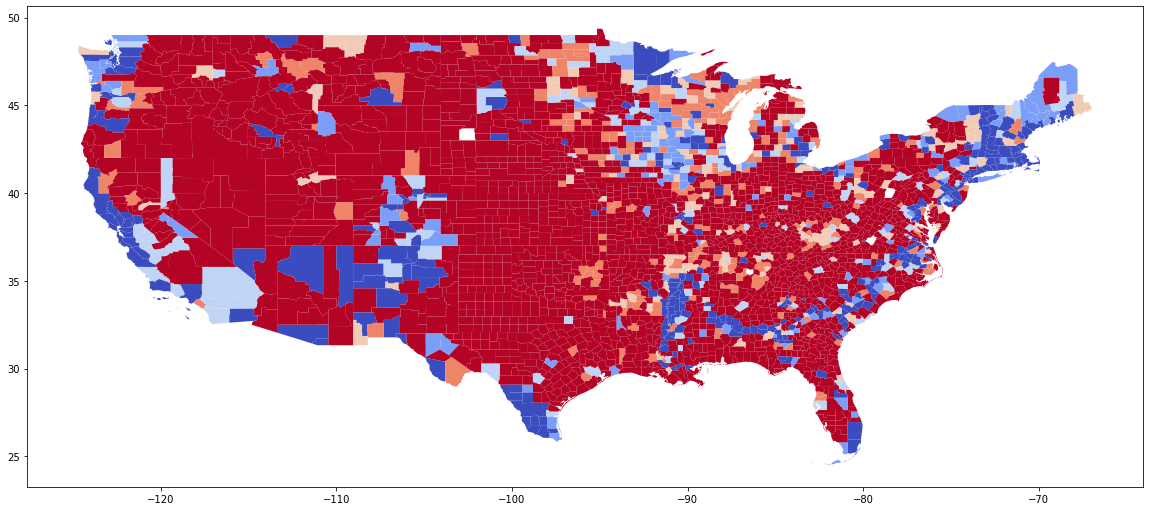

In [1229]:
merged_shape.plot(column='Total', cmap='coolwarm', figsize=(20,10), linewidth=0, edgecolor='white');

In [1238]:
mob.iloc[:, 2:]

,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
87589,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
87590,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
87591,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
87592,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
87593,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
281964,Wyoming,Weston County,2020-04-20,NaN,NaN,NaN,NaN,-38.0,NaN
281965,Wyoming,Weston County,2020-04-21,NaN,NaN,NaN,NaN,-35.0,NaN
281966,Wyoming,Weston County,2020-04-22,NaN,NaN,NaN,NaN,-33.0,NaN
281967,Wyoming,Weston County,2020-04-23,NaN,NaN,NaN,NaN,-34.0,NaN
